In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import mutual_info_classif
file_path = r"adult_with_headers.csv"
df = pd.read_csv(file_path)
df.columns = df.columns.str.strip().str.lower().str.replace('-', '_')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [3]:
print(df.head())

   age          workclass  fnlwgt   education  education_num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital_status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital_gain  capital_loss  hours_per_week  native_country  income  
0          2174             0              40   United-States   <=50

In [4]:
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64


In [8]:
df.fillna(df.mode().iloc[0], inplace=True)
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns
scaler_std = StandardScaler()
scaler_minmax = MinMaxScaler()
df[num_cols] = scaler_std.fit_transform(df[num_cols])  # Standard Scaling
df_minmax = df.copy()
df_minmax[num_cols] = scaler_minmax.fit_transform(df_minmax[num_cols])  # Min-Max Scaling
for col in cat_cols:
    if df[col].nunique() <= 5:
        df = pd.get_dummies(df, columns=[col])  # One-Hot Encoding
    else:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])  # Label Encoding
df['capital_diff'] = df['capital_gain'] - df['capital_loss']
df['hours_per_week_squared'] = df['hours_per_week'] ** 2
df['log_capital_gain'] = np.log1p(df['capital_gain'])
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers = iso_forest.fit_predict(df[num_cols])
df['outlier'] = outliers
df = df[df['outlier'] == 1]
df.drop(columns=['outlier'], inplace=True)
target_col = [col for col in df.columns if 'income' in col.lower()]
if not target_col:
    raise KeyError("Target column 'income' not found. Available columns: ", df.columns)
target_col = target_col[0]
mi_scores = mutual_info_classif(df[num_cols], df[target_col])
mi_scores_df = pd.DataFrame({'Feature': num_cols, 'Mutual Information Score': mi_scores})
mi_scores_df = mi_scores_df.sort_values(by='Mutual Information Score', ascending=False)
print("Mutual Information Scores:")
print(mi_scores_df)

Mutual Information Scores:
          Feature  Mutual Information Score
3    capital_gain                  0.073175
0             age                  0.069628
2   education_num                  0.053621
5  hours_per_week                  0.035099
1          fnlwgt                  0.029384
4    capital_loss                  0.012254


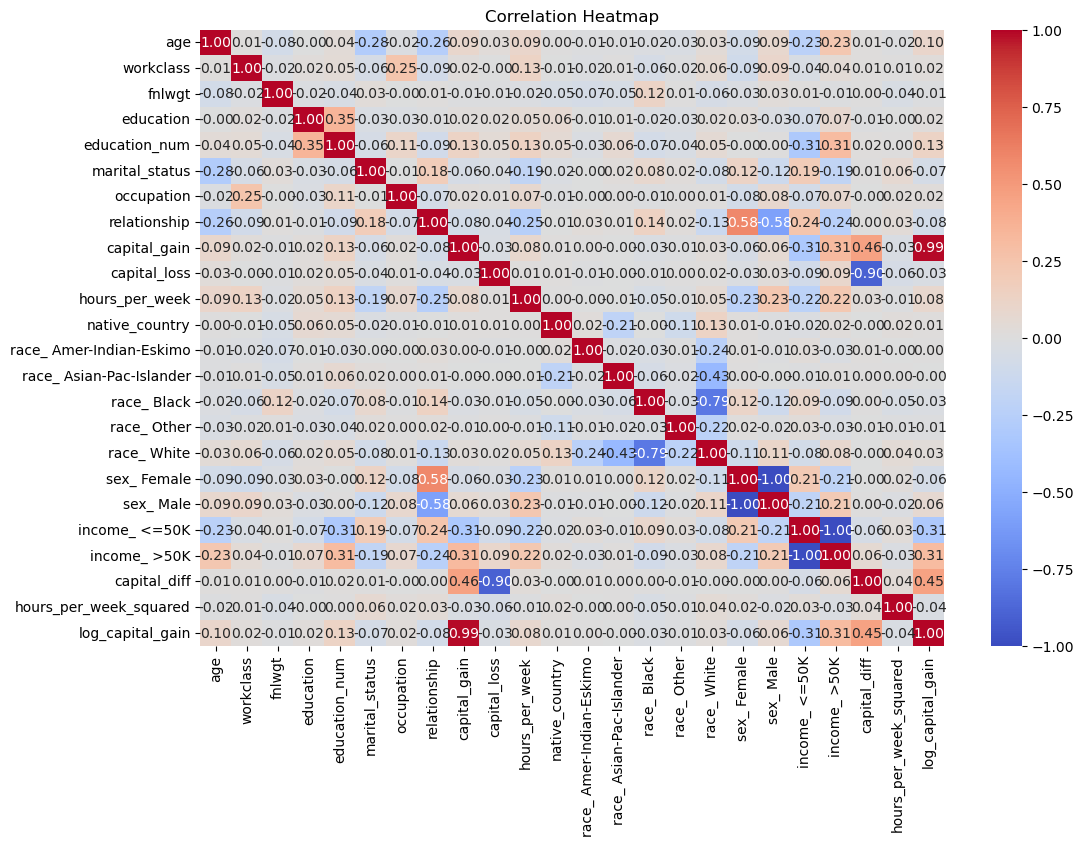

EDA and Feature Engineering Completed.


In [9]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()
print("EDA and Feature Engineering Completed.")
